# Spatial Binning

A major part of the S-test is the ability to generate sub-catalogs based on a lat/lon grid with rectangular elements. When applied to a single catalog, ie., Comcat the binning routine should return a list of catalogs 

The initial implementation is based on Delaunay triangulation, but could implement another point in polygon algorithm.

Algorithm psuedocode:

1. Create polygons from origin points 
2. For each polygon compute delaunay trangulation 
3. Create new catalog based on these events 
4. Return list of catalogs

In [83]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csep
import time
import xml.etree.ElementTree as ET
import shapely
%matplotlib notebook

In [84]:
eps = np.finfo(np.float32).eps

def point_in_polygon(points, vertices):
    """
    Determines whether a point lies within a polygon. Uses delaunay
    triangulation and determines the simplices the query point belongs to.
    If the point is outside the vertices, there would be no simplices found.
    
    Args:
        points (list or scalar)
        vertices (vertices of polygon, do not have to be closed)
        tri: triangulation. used to accelerate computations for multiple queries on same points
        
    Returns:
        result: bool list with same length as points
        
    Note:
        this function is optimized to accept multiple points 
    """
    from scipy.spatial import Delaunay
    tri = Delaunay(vertices)
    results = tri.find_simplex(points)
    # create boolean array from values
    out = results != -1
    return out

def _compute_vertices(origin_point, dh, tol=eps):
    """
    Computes the bounding box of a rectangular polygon given its origin points and spacing dh.
    
    Args:
        origin_points: list of tuples, where tuple is (x, y)
        dh: spacing
        tol: used to eliminate overlapping polygons in the case of a rectangular mesh, defaults to
             the machine tolerance.
        
    Returns:
        list of polygon edges
    
    """
    bbox = ((origin_point[0], origin_point[1]),
            (origin_point[0], origin_point[1] + dh - tol),
            (origin_point[0] + dh - tol, origin_point[1] + dh - tol),
            (origin_point[0] + dh - tol, origin_point[1]))
    return bbox

def compute_vertices(origin_points, dh, tol=eps):
    """
    Wrapper function to compute vertices for multiple points. Default tolerance is set to machine precision
    of floating point number.
    """
    return list(map(lambda x: _compute_vertices(x, dh, tol=tol), origin_points))

def parse_csep_template(xml_filename):
    """
    Reads CSEP XML template file and returns the lat/lon values 
    for the forecast.
    
    Returns:
        list of tuples where tuple is (lon, lat)
    """
    tree = ET.parse(csep_template)
    root = tree.getroot()
    points = []
    for cell in root.iter('{http://www.scec.org/xml-ns/csep/forecast/0.1}cell'):
        points.append((float(cell.attrib['lon']), float(cell.attrib['lat'])))
    return points

In [85]:
dh = 0.1
origin = [(40.15, -125.35)]
p1 = [40.15, -125.35]
p2 = [40.15, -125.30]
p3 = [40.2, -125.30]
p4 = [40.1, -125.30]
p5 = [40.25, -125.35]
bbox = compute_vertices(origin, dh)
print(bbox)
print(point_in_polygon([p1, p2, p3, p4, p5], bbox[0]))

[((40.15, -125.35), (40.15, -125.25000011920929), (40.24999988079071, -125.25000011920929), (40.24999988079071, -125.35))]
[ True  True  True False False]


In [86]:
# build rectangular polygons from CSEP template file
csep_template = os.path.expanduser('~/Projects/CSEP2/Notes/csep_region/csep-forecast-template-M5.xml')
origins = parse_csep_template(csep_template)
polygons = compute_vertices(origins, dh)
print(polygons[0])
print(len(polygons))

# Comcat Synthetics
epoch_time = 709732655000
duration_in_years = 1.0
t0 = time.time()
comcat = csep.load_catalog(type='comcat', format='native',
                        start_epoch=epoch_time, duration_in_years=1.0,
                        min_magnitude=2.5, 
                        min_latitude=31.50, max_latitude=43.00,
                        min_longitude=-125.40, max_longitude=-113.10,
                        name='Comcat')
t1 = time.time()

# Statements about Comcat Downloads
print("Fetched Comcat catalog in {} seconds.\n".format(t1-t0))
print("Downloaded Comcat Catalog with following parameters")
print("Start Date: {}\nEnd Date: {}".format(str(comcat.start_time), str(comcat.end_time)))
print("Min Latitude: {} and Max Latitude: {}".format(comcat.min_latitude, comcat.max_latitude))
print("Min Longitude: {} and Max Longitude: {}".format(comcat.min_longitude, comcat.max_longitude))
print("Min Magnitude: {} and Max Magnitude: {}\n".format(comcat.min_magnitude, comcat.max_magnitude))

print(comcat.get_number_of_events())

((-125.35, 40.15), (-125.35, 40.24999988079071), (-125.25000011920929, 40.24999988079071), (-125.25000011920929, 40.15))
7682
Fetched Comcat catalog in 14.266419172286987 seconds.

Downloaded Comcat Catalog with following parameters
Start Date: 1992-06-28 12:00:59.904000+00:00
End Date: 1993-06-28 02:33:55.456000+00:00
Min Latitude: 31.597166061401367 and Max Latitude: 41.83566665649414
Min Longitude: -125.38899993896484 and Max Longitude: -113.107666015625
Min Magnitude: 2.5 and Max Magnitude: 6.300000190734863

6251


In [87]:
from scipy.spatial import Delaunay

class Polygon:
    """
    Represents polygons defined through a collection of vertices. Used to associate a triangulation
    with a polygon.
    
    This polygon is assumed to be 2d, but could contain an arbitrary number of vertices.
    """
    def __init__(self, points, tri=False):
        # instance members 
        self.points = points
        self.origin = self.points[0]
        
        if tri:
            self.tri = Delaunay(self.points)
    
    def __str__(self):
        return str(self.origin)
        
    def contains(self, points):
        """
        Checks whether point exists in polygon by querying the simpleces determined from the triangulation
        of the polygon.
        
        Args:
            points (list of tuples): tuples represent (x, y) coordinates. If single point is used, it 
            still must be passed to function as a list of tuples.
            
        Returns:
            out (ndarray): bool array depending on whether points are within the polygon.
        """
        results = self.tri.find_simplex(points)
        # create boolean array from values; find_simplex returns -1 if point is not found.
        out = results != -1
        return out
    
    def centroid(self):
        """ return the cetroid of the polygon."""
        c0, c1 = 0, 0
        k = len(self.points)
        for p in self.points:
            c0 = c0 + p[0]
            c1 = c1 + p[1]
        return c0 / k, c1 / k
        
            
####################################################################################################################
origins = parse_csep_template(csep_template)
bboxes = compute_vertices(origins, dh)
polygons = [Polygon(bbox, tri=True) for bbox in bboxes]

def bin_catalog_spatial(catalog, polygons):
    """
    Applys a polygon-based binning procedure to a catalog or stochastic event set. This function is used
    to partition . For stochastic event sets, this function
    will be called on the individual catalogs.
    
    Args:
        catalog: `csep.base.Catalog`
        polygons (list of `csep.utils.regions.Polygon`)
        
    Returns:
        out: (list of catalogs, where each catalog is bounded by the polygon).
    """
    split_catalogs = []

    # get spatial locations from catalog
    lats = catalog.get_latitudes()
    lons = catalog.get_longitudes()
    points = [(lon, lat) for lon, lat in zip(lons, lats)]

    agg = 0
    for poly in polygons:
        mask = poly.contains(points)
        # create new structured numpy array containing events in polygon
        events = np.array(catalog.catalog[mask], dtype=catalog.dtype)
        # create new catalog object
        new_catalog = catalog.__class__(catalog=events, 
                                        catalog_id=poly.origin,
                                        name=str(poly.origin),
                                        region=poly)
        split_catalogs.append(new_catalog)
        
    return split_catalogs

TODO:

1. Catalogs need consistent member for dtype (ie, not comcat_dtype, but just dtype)
2. Binning should be callable on original class instance to return list of sub-catalogs, state should be copied/updated where necessary.
3. Initially keep this functionality separate from classes themselves. This might want to be bound to the class, but is not necessary 

Binned 1 catalog in 16.877111673355103 seconds.


<IPython.core.display.Javascript object>


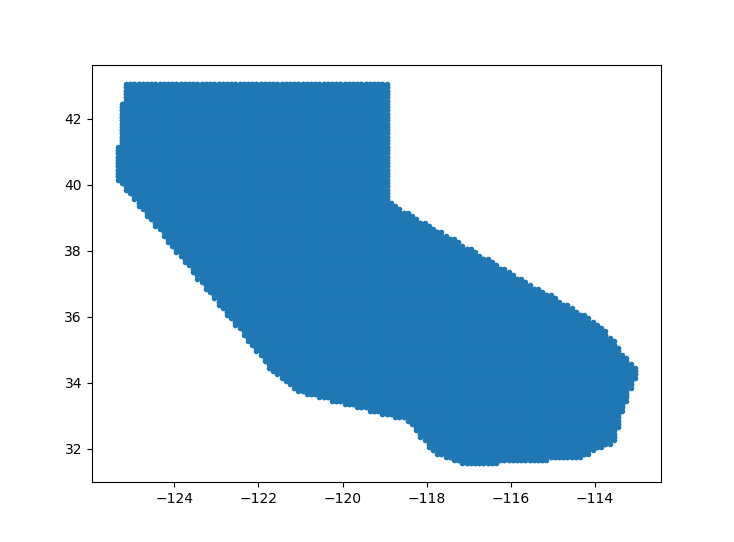

In [163]:
t0 = time.time()
split_catalogs = bin_catalog_spatial(comcat, polygons)
t1 = time.time()
print('Binned 1 catalog in {} seconds.'.format(t1-t0))

fig = plt.figure()
ax = fig.gca()
plot_polygons = np.array([catalog.region.points for catalog in split_catalogs])
f,s,t = plot_polygons.shape
plot_polygons = plot_polygons.reshape([f*s,t])
ax.plot(plot_polygons[:,0], plot_polygons[:,1], '.')

### Implementation of Spatial binning optimized for CSEP grids

New algorithm takes a two-part approach to solving this problem and assumes that we have a network of polygons that where the polygon dimensions are constant, $h_x = c_1$ and $h_y = c_2$ but $h_x$ does not necessarily equal $h_y$. The first part of this algorithm defines a bitmask matrix $A_{ij}$ containing a 0 or 1 depending on whether not not the polygon exists within a bounding box of the set of polygons. Second, the points are binned using a hash-function that computes $id_x$ and $id_y$. The output is aggregated by applying this mask to the set.

### Developing mask function

[Explain the process for developing the hashing algorithm]

In [89]:
def bin1d(p, bins):
    """
    given bins defined by their edges (scalar), return the index of p in bins.
    it's assumed that bins in monotonically increasing and sorted. additionally, its assumed
    that bins are equally spaced.
    
    returns:
        index in bin, -1 if outside range.
    """
    a0 = np.min(bins)
    h = bins[1] - bins[0]
    idx = np.floor((p - a0) / h)
    if idx < 0 or idx >= len(bins)-1:
        idx = -1
    return idx

In [90]:
def bin1d_vec(p, bins):
    """
    same as bin1d but optimized for vectorized calls.
    """
    a0 = np.min(bins)
    h = bins[1] - bins[0]
    idx = np.floor((p-a0)/h)
    idx[((idx<0)|(idx>=len(bins)-1))] = -1
    return idx.astype(np.int)

In [91]:
import traceback
import sys

# functions are objects!!
def test_function(func):
    func._is_test = True
    return func

def run_tests(obj, *args, **kwargs):
    funcs = {}
    for name in dir(obj):
        attr = getattr(obj, name)
        if callable(attr) and not name.startswith('__'):
            if getattr(attr, '_is_test', True):
                funcs[name] = attr
    for name, func in funcs.items():
        try:
            func(*args, **kwargs)
        except AssertionError:
            print('Test {} failed! See stack trace.'.format(name))
            _, _, tb = sys.exc_info()
            traceback.print_tb(tb)
            print()
        else:
            print('{} passed!'.format(name))

In [92]:
class TestHashFunction:
    def __init__(self):
        self.bins = np.array([1.5, 2.5, 3.5, 4.5, 5.5])
        
    @test_function
    def test_on_boundary(self):
        p = 1.5
        idx = bin1d(p, self.bins)
        assert idx == 0
        
    @test_function
    def test_inside(self):
        p = 2.0
        idx = bin1d(p, self.bins)
        assert idx == 0
    
    @test_function
    def test_outside_lower(self):
        p = 1.0
        idx = bin1d(p, self.bins)
        assert idx == -1
    
    @test_function
    def test_outside_upper(self):
        p = 5.6
        idx = bin1d(p, self.bins)
        assert idx == -1
        
    @test_function
    def test_on_boundary(self):
        p = 5.5
        idx = bin1d(p, self.bins)
        assert idx == -1
    
    @test_function
    def test_just_inside_upper(self):
        p = 5.49
        idx = bin1d(p, self.bins)
        assert idx == 3

In [118]:
class TestVecHashFunction:
    def __init__(self):
        self.bins = np.array([1.5, 2.5, 3.5, 4.5, 5.5])
        
    @test_function
    def test_vectorized(self):
        p = [1.5, 2.0, 1.0, 5.6, 5.5, 5.49]
        idx = bin1d_vec(p, self.bins)
        assert np.alltrue(idx==np.array([0, 0, -1, -1, -1, 3]))

In [119]:
# run tests using test runner
print('Running tests!')
print('==============')
test_classes = (TestHashFunction(),TestVecHashFunction())
for test_class in test_classes:
    run_tests(test_class)

Running tests!
test_inside passed!
test_just_inside_upper passed!
test_on_boundary passed!
test_outside_lower passed!
test_outside_upper passed!
test_vectorized passed!


[(-125.35, 31.55), (-113.15, 42.95)] 0.1
built bitmask in 0.1700608730316162 seconds.


<IPython.core.display.Javascript object>


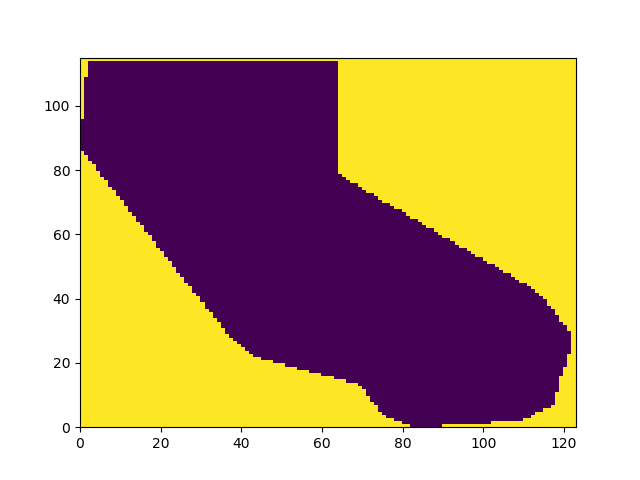

In [102]:
def build_bitmask(polygons):
    
    # build bounding box of set of polygons based on origins
    nd_origins = np.array([poly.origin for poly in polygons])
    bbox = [(min(nd_origins[:,0]), min(nd_origins[:,1])),
            (max(nd_origins[:,0]), max(nd_origins[:,1]))]
    print(bbox, dh)
    
    # get midpoints for hashing
    midpoints = np.array([poly.centroid() for poly in polygons])

    # compute nx and ny
    nx = np.rint((bbox[1][0] - bbox[0][0])/dh)
    ny = np.rint((bbox[1][1] - bbox[0][1])/dh)

    # set up grid of bounding box
    xs = dh*np.arange(nx+1)+bbox[0][0]
    ys = dh*np.arange(ny+1)+bbox[0][1]
    
    # set up mask array, 1 is where we want to mask
    a = np.ones([len(ys), len(xs), 2])
    for i, mp in enumerate(midpoints):
        idx, idy = int(bin1d(mp[0], xs)), int(bin1d(mp[1], ys))
        # store index of polygon
        a[idy, idx, 1] = i
        if idx >= 0 and idy >= 0:
            a[idy, idx, 0] = 0
    return a, xs, ys

t0 = time.time()
a, ai, bi = build_bitmask(polygons)
t1 = time.time()
print('built bitmask in {} seconds.'.format(t1-t0))

# bind this shit to the catalog, will create some type of class
plt.figure()
comcat.aij = a
comcat.ai = ai
comcat.bi = bi
plt.pcolor(comcat.aij[:,:,0])

[(-125.35, 31.55), (-113.15, 42.95)] 0.1
built bitmask in 0.04922008514404297 seconds.


<IPython.core.display.Javascript object>


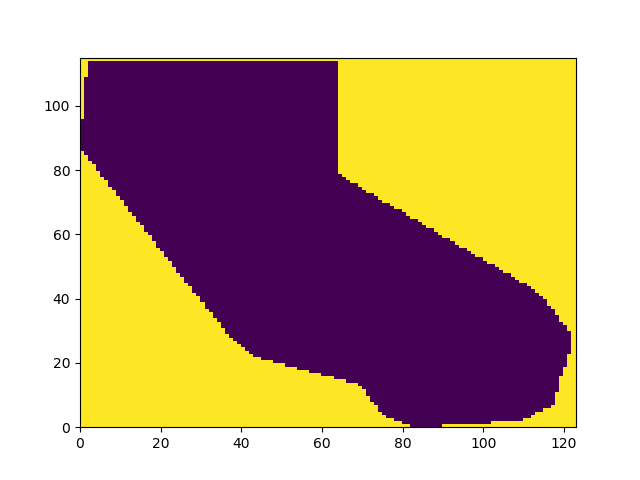

In [162]:
def build_bitmask_vec(polygons):
    
    # build bounding box of set of polygons based on origins
    nd_origins = np.array([poly.origin for poly in polygons])
    bbox = [(min(nd_origins[:,0]), min(nd_origins[:,1])),
            (max(nd_origins[:,0]), max(nd_origins[:,1]))]
    print(bbox, dh)
    
    # get midpoints for hashing
    midpoints = np.array([poly.centroid() for poly in polygons])

    # compute nx and ny
    nx = np.rint((bbox[1][0] - bbox[0][0])/dh)
    ny = np.rint((bbox[1][1] - bbox[0][1])/dh)

    # set up grid of bounding box
    xs = dh*np.arange(nx+1)+bbox[0][0]
    ys = dh*np.arange(ny+1)+bbox[0][1]
    
    # set up mask array, 1 is where we want to mask
    a = np.ones([len(ys), len(xs), 2])
    idx = bin1d_vec(midpoints[:,0], xs)
    idy = bin1d_vec(midpoints[:,1], ys)

    for i in range(idx.shape[0]):
        # store index of polygon
        a[idy[i], idx[i], 1] = i
        if idx[i] >= 0 and idy[i] >= 0:
            a[idy[i], idx[i], 0] = 0
    return a, xs, ys

t0 = time.time()
a, ai, bi = build_bitmask_vec(polygons)
t1 = time.time()
print('built bitmask in {} seconds.'.format(t1-t0))

# bind this shit to the catalog, will create some type of class 
plt.figure()
comcat.aij = a
comcat.ai = ai
comcat.bi = bi
plt.pcolor(comcat.aij[:,:,0])

In [12]:
from collections import defaultdict

def bin_catalog_spatial_opt(catalog, polygons, bitmask, bins):
    """
    Returns a list of sub-catalogs where each catalog contains a list of catalogs containing the events that occur
    within that polygon.
    """
    binned_events = defaultdict(list)
    ny, nx, _ = bitmask.shape
    ai, bi = bins
    
    lons = catalog.get_longitudes()
    lats = catalog.get_latitudes()

    # get index for each rupture in catalog
    for i, p in enumerate(zip(lons, lats)):

        # index in cartesian grid
        idx, idy = int(bin1d(p[0], ai)), int(bin1d(p[1], bi))

        # we store the index of that polygon in array
        if not bitmask[idy,idx,0]:
            hash_idx = int(bitmask[idy,idx,1])
            binned_events[hash_idx].append(catalog.catalog[i])

    split_catalog = binned_to_catalog(catalog, binned_events, polygons)

    return split_catalog

def binned_to_catalog(catalog, binned_events, polygons):
    """
    takes a dict of binned events (ndarray) and list of polygons and returns a list of the split catalogs.
    
    when implemented on the catalog class this information will be made available.
    """
    # create catalogs after we're done
    split_catalogs = []
    n = len(polygons)
    for i in range(n):
        events = np.array(binned_events[i], dtype=catalog.dtype)

        # create new catalog object
        new_catalog = catalog.__class__(catalog=events,
                                        catalog_id=i,
                                        name=catalog.name + '_binned',
                                        region='California')
        split_catalogs.append(new_catalog)
        
    # might want to sort them by the index or something.
    return split_catalogs

In [14]:
mw_min = 3.5

# Filenames of target simulations
project_root = '/Users/wsavran/Projects/CSEP2/u3etas_simulations/landers_experiment'
filename = os.path.join(project_root, '10-23-2018_landers-pt1/results_complete.bin')
filename_nofaults = os.path.join(project_root, '10-31-2018_landers-nofaults-pt1/results_complete.bin')

# Load Stocahstic Event Set
t0 = time.time()
u3catalogs = csep.load_stochastic_event_set(filename=filename, type='ucerf3', format='native', name='UCERF3-ETAS')
# Example of functional programming to apply function to stochastic event set
u3catalogs_filt = map(lambda x: x.filter('magnitude > {}'.format(mw_min)), u3catalogs)
t1 = time.time()

In [15]:
t0 = time.time()
binned_events = bin_catalog_spatial_opt(comcat, polygons, comcat.aij, (comcat.ai, comcat.bi))
t1 = time.time()
print('Binned 1 catalog in {} seconds.'.format(t1-t0))

Binned 1 catalog in 0.2712888717651367 seconds.


In [16]:
counts = sum([sub_cat.get_number_of_events() for sub_cat in split_catalogs])
print(counts)

6198


In [17]:
def chunks(l, n):
    """
    splits list l into n chunks. order is not preserved.
    """
    for i in range(n):
        yield l[i::n]

Function *chunks(l, n)* is used to chunk the stochastic event set into $n$ chunks for distributing computing across multiple processors.